In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import os
import shutil

In [6]:
good_name_dataset = {
    'bin_2': 'bin4U',
    'bin_5': 'bin3U', 
    'pref': 'pref3U', 
    "enron" : "enron",
    "congress" : "congress",
    "contact" : "contact",
    "dblp": "dblp",
    'aminer': 'aminer'
}
fontsize = 28
labelsize = 20

Efficiency Analysis (Local-Core)
---------
### Figure 6

In [3]:
# datasets = ["bin_2",  "bin_5", "contact","enron", "congress"]
datasets = ["bin_2",  "bin_5", "contact","enron", "pref", "congress", "dblp", "aminer"]
num_verts = []
wrong_core_numbers = []
wrong_core_perc = []
avg_abserror = []

for data in datasets:
    print(data)
    source_fname = "../output/core_Peel_"+data+".csv"
    target_fname = "../output/wrong_core_"+data+".csv"
    df1 = pd.read_csv(source_fname, header=None)
    df2 = pd.read_csv(target_fname, header=None)

    cnt = 0
    sz = len(df1[0])
    if(len(df1[0])!=len(df2[0])):
        print("Number of vertices do not match")
        exit()
    # print(df1[0])
    # print(sz)
    l1 = [0]*sz
    l2 = [0]*sz

    error = 0
    for i in range(sz):
        if(df1.iat[i,1]!=df2.iat[i,1]):
            cnt+=1
        error += abs(df1.iat[i,1] - df2.iat[i,1])/sz

    num_verts.append(sz)
    wrong_core_numbers.append(cnt)
    wrong_core_perc.append(cnt/sz*100)
    avg_abserror.append(error)

bin_2
bin_5
contact
enron
pref
congress
dblp
aminer


In [7]:
wrong_core_df = pd.DataFrame({'dataset':datasets,'N':num_verts,'#wrongCore':wrong_core_numbers, '%wrongCore':wrong_core_perc})
wrong_core_df = wrong_core_df.replace({"dataset": good_name_dataset})
print(wrong_core_df.head(10))

    dataset         N  #wrongCore  %wrongCore
0     bin4U       500         496   99.200000
1     bin3U       500         496   99.200000
2   contact       242          37   15.289256
3     enron      4423        1171   26.475243
4    pref3U    125329        6533    5.212680
5  congress      1718        1657   96.449360
6      dblp   1836596      330164   17.976953
7    aminer  27850748     2853234   10.244730


`Fig 6(a)`

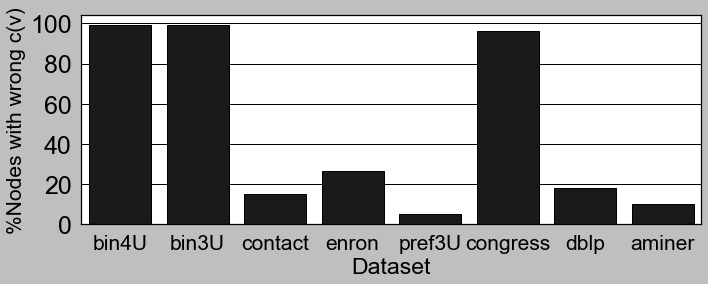

In [8]:
sns.set(rc={'figure.figsize':(10,4)})
sns.set_style("whitegrid", {'axes.grid' : True})
# sns.set_style("ticks")
plt.style.use('grayscale')

sns.barplot(x='dataset', y='%wrongCore', data=wrong_core_df, color='k',hue_order=datasets)
plt.xlabel('Dataset', fontsize=fontsize-5)
plt.ylabel('%Nodes with wrong c(v)', fontsize=fontsize-7)
plt.xticks(fontsize=fontsize-7)
plt.yticks(fontsize=fontsize-3)
plt.tight_layout()
plt.savefig('../fig/WrongCore.pdf')
plt.show()

``Expt-2``

In [12]:
import numpy as np
datalist = ['pref', 'enron', 'bin_5', 'bin_2', 'dblp']
hypH_errors = {}
grH_errors = {}

def read_iterations_hindices(source):
    source_dicts = {}
    with open(source,'r') as f:
        nodes = []
        i = 0
        for line in f.readlines():
            # line = line.strip()
            if i==0:
                line = line.split(",")
                line = line[:-1]
                for l in line:
                    nodes.append(int(l))
            else:
                source_dicts[i] = {}
                line = line.split(",")
                line = line[:-1]
                for node,l in zip(nodes,line):
                    cv = int(l)
                    source_dicts[i][node] = cv
            i+=1
    return source_dicts

for data in datalist: 
    print(data)
    target = "../output/core_Peel_"+data+".csv" # baseline core
    source = "../output/log_Local-core_"+data+".csv" # hypergraph h-index
    source2 = "../output/wrong_core_log_"+data+".csv" # graph h-index
    target_dict = {} # baseline
    source_dicts = {} # hyp h-index
    source_dicts2 = {} # graph h-index
    mean_errors = {}
    mean_errors2 = {}
    # Read baseline core
    with open(target,'r') as f:
        for line in f.readlines():
            node,cv = line.split(',')
            target_dict[int(node)] = int(cv) 
    
    # Read hyp h-index per iteration
    source_dicts = read_iterations_hindices(source)
    num_iterations_hypHindex = len(source_dicts)+1
    # Read graph h-index per iteration
    source_dicts2 = read_iterations_hindices(source2)
    num_iterations_gHindex = len(source_dicts2)+1
#     print(len(source_dicts),' ',len(source_dicts2))

    for it in range(1,num_iterations_hypHindex):
        n = len(target_dict)
        error = 0
        for k,val in source_dicts[it].items():
            error += np.abs(val - target_dict[k])
        mean_errors[it] = error/n
    
    for it in range(1,num_iterations_hypHindex):
        n = len(target_dict)
        error = 0
        # #iterations (Gr. h-index) < #iterations (Hyp. hindex) => We replicate the converged iteration state of Graph h-index,
        # because beyond converged iteration all nodes have the same graph h-index.
        if it >= num_iterations_gHindex: 
            mean_errors2[it] = mean_errors2[it-1]
        else:
            for k,val in source_dicts2[it].items():
                error += np.abs(val - target_dict[k])
            mean_errors2[it] = error/n
    
    print('#it(gr): ',num_iterations_gHindex,' #it(hyp):',num_iterations_hypHindex)
    
    hypH_errors[data] = [mean_errors[i] for i in range(1,num_iterations_hypHindex)]
    grH_errors[data] = [mean_errors2[i] for i in range(1, num_iterations_hypHindex)]

pref
#it(gr):  15  #it(hyp): 8
enron
#it(gr):  30  #it(hyp): 11
bin_5
#it(gr):  11  #it(hyp): 9
bin_2
#it(gr):  10  #it(hyp): 10
dblp
#it(gr):  51  #it(hyp): 53


`Fig 6(b)`

enron


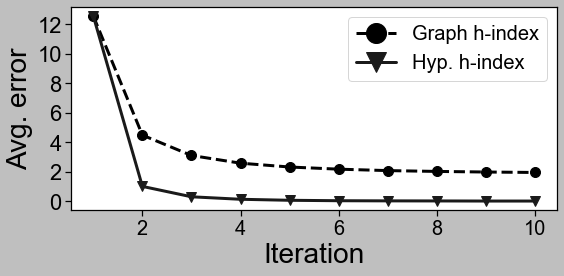

In [13]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')
marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist)]
i = 1
data = datalist[i]
print(good_name_dataset[data])
X = range(1,len(hypH_errors[data])+1)
plt.plot(X,grH_errors[data],'.--',marker = marker_list[1], markersize = 10,label='Graph h-index',lw=3)
plt.plot(X,hypH_errors[data],marker = marker_list[2],color = 'k', markersize = 10,label='Hyp. h-index',lw=3)
# print(Xs[0])
# print(Mean_errors[0])
# print(Mean_errors2[0])
plt.xlabel("Iteration", fontsize=fontsize)
plt.ylabel("Avg. error",fontsize= fontsize)
# plt.yscale('log')
# plt.title(good_name_dataset[data])
plt.xticks(fontsize=fontsize-8)
plt.yticks(fontsize=fontsize-6)
plt.legend(loc = 'best', fontsize=labelsize,markerscale=2)
plt.tight_layout()
plt.savefig('../fig/error_hindex_'+good_name_dataset[data]+'.pdf')
plt.show()

`Fig 6(c)`

bin4U


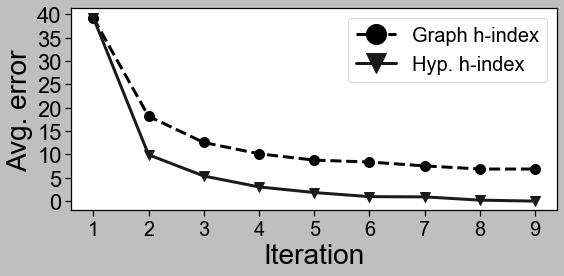

In [14]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')
marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist)]

i = 3
data = datalist[i] 
print(good_name_dataset[data])
X = range(1,len(hypH_errors[data])+1)
plt.plot(X,grH_errors[data],'.--',marker = marker_list[1], markersize = 10,label='Graph h-index',lw = 3)
plt.plot(X,hypH_errors[data],marker = marker_list[2],color = 'k', markersize = 10,label='Hyp. h-index',lw = 3)


plt.xlabel("Iteration", fontsize=fontsize)
plt.ylabel("Avg. error",fontsize= fontsize)
# plt.yscale('log')
# plt.title(good_name_dataset[data])
plt.xticks(fontsize=fontsize-8)
plt.yticks(fontsize=fontsize-6)
plt.legend(loc = 'best', fontsize=labelsize,markerscale=2)
plt.tight_layout()
plt.savefig('../fig/error_hindex_'+good_name_dataset[data]+'.pdf')
plt.show()

`Fig 6(d)`

In [50]:
datalist = ['pref', 'enron', 'bin_5','bin_2','dblp']
Xs = {}
Ys = {} 

def read_iterations_hindices(source):
    source_dicts = {}
    with open(source,'r') as f:
        nodes = []
        i = 0
        for line in f.readlines():
            # line = line.strip()
            if i==0:
                line = line.split(",")
                line = line[:-1]
                for l in line:
                    nodes.append(int(l))
            else:
                source_dicts[i] = {}
                line = line.split(",")
                line = line[:-1]
                for node,l in zip(nodes,line):
                    cv = int(l)
                    source_dicts[i][node] = cv
            i+=1
    return source_dicts

for data in datalist: 
    print(data)
    target = "../output/core_Peel_"+data+".csv" # baseline core
    source = "../output/log_Local-core_"+data+".csv" # hypergraph h-index
    source2 = "../output/wrong_core_log_"+data+".csv" # graph h-index
    target_dict = {} # baseline
    source_dicts = {} # hyp h-index
    source_dicts2 = {} # graph h-index
    correct_perc = {} # % correct core-number at iteration i (hyp h-index)
    mean_errors = {}
    mean_errors2 = {}
    # Read baseline core
    with open(target,'r') as f:
        for line in f.readlines():
            node,cv = line.split(',')
            node = int(node)
            cv = int(cv)
            target_dict[node] = cv 
    
    # Read hyp h-index per iteration
    source_dicts = read_iterations_hindices(source)
    num_iterations_hypHindex = len(source_dicts)+1

    for it in range(1,num_iterations_hypHindex):
        n = len(target_dict)
        num_cor = 0
        for k,val in source_dicts[it].items():
            if val == target_dict[k]:
                num_cor+=1
        correct_perc[it] = (num_cor * 100.0)/n
    
    Xs[data] = sorted(list(correct_perc.keys()))
    Ys[data] = [correct_perc[i] for i in Xs[data]]

pref
enron
bin_5
bin_2
dblp


In [15]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(9,5)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')

datalist2 = ['pref', 'dblp', 'enron','bin_5','bin_2']
# datalist2 = datalist[:5]
# marker_list = list(Line2D.markers)
marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist2)]
for i,data in enumerate(datalist2):
    plt.plot(Xs[data],Ys[data],label=good_name_dataset[data],marker = marker_list[i], color = 'k', markersize = 10)
plt.xscale('log',base=2)
plt.xlabel("Iteration", fontsize=fontsize-2)
plt.ylabel("%Nodes with correct c(v)",fontsize= fontsize-4)
plt.xticks(fontsize=fontsize-4)
plt.yticks(fontsize=fontsize-4)
plt.legend(loc = 'lower right', fontsize=labelsize,markerscale=2)
# plt.legend(loc = 'lower right', fontsize=labelsize-4,markerscale=1,mode = "expand", ncol = 2)
plt.tight_layout()
plt.savefig('../fig/Convergence.pdf')
plt.show()

NameError: name 'Xs' is not defined

In [133]:
# def get_nbrs(dataset):
#     _dict = {}
#     with open('hgstats/output/setnbrs_'+dataset+'.csv') as rf:
#         for line in rf:
#             strline = line.strip()
#             l = strline.split(',')
#             _dict[l[0]] = l[1:]
#     return _dict
# def get_core(dataset):
#     _dict = {}
#     with open('output/core_Peel_'+dataset+'.csv') as rf:
#         for line in rf:
#             strline = line.strip()
#             l = strline.split(',')
#             _dict[l[0]] = l[1]
#     return _dict

In [191]:
# d = 'pref'
# source_dicts = read_iterations_hindices("output/log_Local-core_"+d+".csv") # hypergraph h-index
# dict1 = get_nbrs(d)
# core = get_core(d)
# dd = {}
# converged = []
# conv_numnbrs = []
# for v in core:
#     cv = int(core[v])
#     count = 0
#     N_v = len(dict1[v])
#     if source_dicts[3][int(v)]==cv:
#         converged.append(int(v))
#         conv_numnbrs.append(N_v)
#     for u in dict1[v]:
#         cu = core[u]
#         if cu != N_v:
#             count+=1
#     dd[int(v)] = count*100.0/N_v

In [16]:
# # x = dd.keys()
# # y = [dd[i] for i in x]
# # plt.plot(x,y)
# # plt.title(d)
# # plt.show()
# # source_dicts[1]
# plt.scatter(converged, conv_numnbrs)
# plt.show()

In [17]:
# import numpy as np
# from scipy import stats

# d = 'bin_2'
# source_dicts = read_iterations_hindices("output/log_Local-core_"+d+".csv") # hypergraph h-index
# core = get_core(d)
# dict1 = get_nbrs(d)
# nodes = [v for v in core]
# num_nbrs = [len(dict1[v]) for v in nodes]
# nodes = [int(v) for v in nodes]
# average_nbr_converged = {}
# mode_converged = {}
# # print(nodes[1],' ',num_nbrs[1])
# iterations = sorted(list(source_dicts.keys()))
# for it in iterations[:3]:
#     colors = []
#     conv_numnbrs = []
#     for i,v in enumerate(nodes):
#         cv = int(core[str(v)])
#         if source_dicts[it][v]==cv:
#             colors.append('r')
#             conv_numnbrs.append(num_nbrs[i])
#         else:
#             colors.append('k')
    
#     average_nbr_converged[it] = np.mean(conv_numnbrs)
#     mode_converged[it] = stats.mode(conv_numnbrs)[0]
#     plt.scatter(nodes,num_nbrs,color = colors,s=1)
#     plt.yscale('log')
#     plt.title('iteration: '+str(it))
#     plt.show()
#     plt.clf()

In [ ]:
# print(good_name_dataset[d])
# print(average_nbr_converged)
# print(mode_converged)

bin4U
{1: 186.0, 2: 187.33333333333334, 3: 189.0}
{1: array([186]), 2: array([186]), 3: array([186])}


In [18]:
# import numpy as np
# from scipy import stats

# for d in ['pref', 'enron', 'contact','bin_5','bin_2', 'congress','dblp']:
#     source_dicts = read_iterations_hindices("output/log_Local-core_"+d+".csv") # hypergraph h-index
#     core = get_core(d)
#     dict1 = get_nbrs(d)
#     nodes = [v for v in core]
#     num_nbrs = [len(dict1[v]) for v in nodes]
#     nodes = [int(v) for v in nodes]
#     mode_converged = {}
#     perc_nodes_lt_mode = {}
#     iterations = sorted(list(source_dicts.keys()))
#     for it in iterations[:1]:
#         colors = []
#         conv_numnbrs = []
#         for i,v in enumerate(nodes):
#             cv = int(core[str(v)])
#             if source_dicts[it][v]==cv:
#                 colors.append('r')
#                 conv_numnbrs.append(num_nbrs[i])
#             else:
#                 colors.append('k')

#         mode_converged[it] = stats.mode(conv_numnbrs)[0]
        
#         count= 0
#         for i,v in enumerate(nodes):
#             if num_nbrs[i]<= mode_converged[it]:
#                 count+=1
#         perc_nodes_lt_mode[it] = count*100.0/len(nodes)
#     print(good_name_dataset[d])
#     print('mode(#nbrs): ',mode_converged)
#     print(perc_nodes_lt_mode)

Efficiency Evaluation
-------

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import os
import shutil

output_folder = '../output/'
parallel_outfolder = '../output/parout/'
fontsize = 28
labelsize = 20

In [21]:
df1 = pd.read_csv(output_folder+"results.csv", header = None)
df1.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"]
df2 = pd.read_csv(parallel_outfolder+"results.csv", header = None)
df2.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"]
df2 = df2[df2.num_threads == 64].copy()
df = pd.concat([df1,df2])
print(df.shape)
print(df.dataset.unique())
df.head()

(190, 5)
['syn' 'enron' 'bin_1' 'bin_2' 'bin_4' 'bin_5' 'contact' 'congress' 'pref'
 'dblp' 'weeplaces' 'gowalla' 'aminer' 'default']


,algo,dataset,execution time,num_threads,total iteration
0,Local-core-OPTIII(P2),syn,0.000265,1,2
1,Local-core-opt-core-correct,syn,0.000442,1,2
2,Local-core,syn,0.000432,1,2
3,Local-core-OPTIII(P2),enron,0.599341,1,8
4,Local-core-opt-core-correct,enron,1.476749,1,5


In [22]:
good_name = {
    'bucket update time' : 'Bucket time (s)', 
    'execution time' : "Execution time (s)", 
    'neighborhood call time' : "NB time (s)", 
    'subgraph computation time' : "Sub time(s)",
    'num bucket update' : "#bucket", 
    'num neighborhood computation' : "#nb",
    'num subgraph call' : "#subgraph",
    'outerloop time': "outloop time(s)",
    'init time': 'init time(s)',
    'total iteration': '#total iterations',
    'inner iteration': '#inner iterations',
    'memory taken': 'Memory (MB)',
    'core_correction time': 'Core-corection time(s)',
    'h_index_time': 'h-index time(s)',
    'sum_core_correction_volume' : 'Sum Core-correction vol',
    'tau': '#Iterations'
    # 'num_threads' : '#Threads'
}

# NBR(1) adopts Arijits simplification to Bishwa's simplification.
good_name_algo = {
    'Peel' : "Peel", 
    'E-Peel': "E-Peel", 
    'Local-core': "Local-core",
    'Local-core-OPTI': "Local+I",
    'Local-core-OPTII': "Local+I+II",
    'Local-core-OPTIII': "Local+I+II+III",
    'Local-core-OPTIV': "Local-core(OPT)",
    'LocalP(B+CSR)2': "Local-core(P)/64T"
}

good_name_dataset = {
    'bin_2': 'bin4U',
    'bin_5': 'bin3U', 
    'pref': 'pref3U', 
    "enron" : "enron",
    "congress" : "congress",
    "contact" : "contact",
    "dblp": "dblp",
    'aminer': 'aminer'
}
order=["Peel", "E-Peel", "Local-core-OPTIV"]
# order=["Peel", "E-Peel", "Local-I","Local-II","Local-III"]
linewidth= 2
scatterplotBall = 150
save = True

`Fig 7(a+b)`

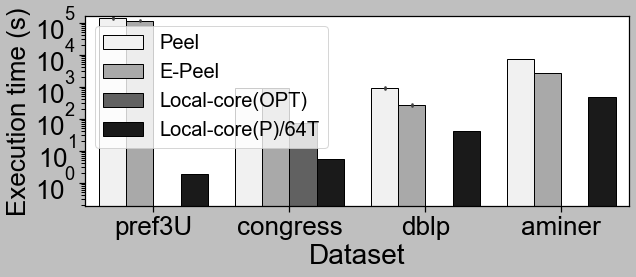

0.1820909 176999.79510119997


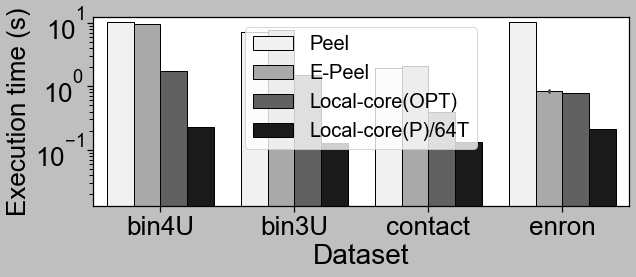

<Figure size 648x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt 
import seaborn as sns 
# print(plt.style.available)
sns.set(rc={'figure.figsize':(9,4)})
# sns.set_style("whitegrid", {'axes.grid' : True})
sns.set_style("ticks")
plt.style.use('grayscale')

save = True
markers = ['o',"s",'x']

include_algos = ["Peel", "E-Peel", "Local-core-OPTIV", 'LocalP(B+CSR)2']
ord = [good_name_algo[i] for i in include_algos]
group_list = ['dataset']
include_datasets = ['pref','congress','dblp','aminer']
# include_datasets = ['congress','dblp', 'aminer']
# columns = ['execution time']

working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df = working_df[working_df['num_threads']==1].copy()
# working_df = working_df[working_df['num_threads']==1].copy()
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

# print(working_df.groupby(['dataset','algo'])['execution time'].mean())
# _min = working_df[y_axis].min()
# donotdrawline = working_df[y_axis].max() <= 20*_min
# working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets, color='k')
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize-2)
plt.yscale("log")
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.ylim(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.1)

# plt.title()
# plt.legend(loc = 'upper left', fontsize=labelsize-4, mode = "expand", ncol = 4) # ,bbox_to_anchor =(0.65, 1.25), mode = "expand", ncol = 3
plt.legend(fontsize=labelsize)
# plt.legend(loc = 'upper center', fontsize=labelsize-4,mode = "expand", ncol = 4)
plt.tight_layout()
filename = ("large " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("../fig/" + filename + ".pdf")
    plt.show()
else:
    print(filename)
    plt.show()
plt.clf()

print(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.2)

include_datasets = ['bin_2','bin_5','contact','enron']
# columns = ['execution time']
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

# print(working_df.groupby(['dataset','algo'])['execution time'].mean())
# _min = working_df[y_axis].min()
# donotdrawline = working_df[y_axis].max() <= 20*_min
# working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets,color='k')
# ax.yaxis.set_major_locator(MaxNLocator(5)) 
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize-2)
plt.yscale("log")
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.ylim(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.2)

plt.legend(fontsize=labelsize, loc = 'upper center')
# plt.legend(loc = 'upper center', fontsize=labelsize-4,mode = "expand", ncol = 4)
plt.tight_layout()
filename = ("small " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("../fig/" + filename + ".pdf")
    plt.show()
else:
    print(filename)
    plt.show()
plt.clf()

Expt-4: Impact of optimizations
--------
`Fig 7(c+d)`

dataset   algo               
aminer    Local-core             16929.279937
          Local-core+I+III+IV     1212.474752
congress  Local-core               235.079339
          Local-core(OPT)           71.649156
          Local-core+I             287.807241
          Local-core+I+III         159.168820
          Local-core+I+III+IV      146.323623
dblp      Local-core              2051.404718
          Local-core+I+III+IV      273.894441
pref3U    Local-core                30.388768
          Local-core+I+III+IV        5.928694
Name: execution time, dtype: float64


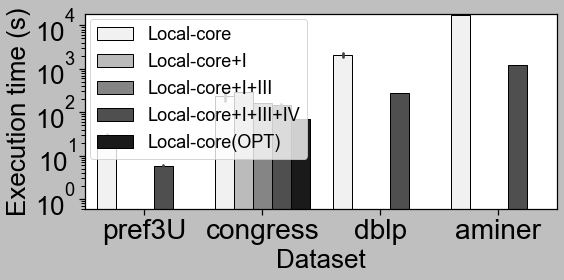

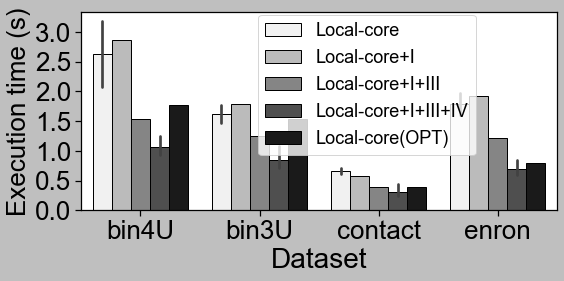

<Figure size 576x288 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt 
# from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')

save = True

good_name_algo = {
    'Peel' : "Peel", 
    'E-Peel': "E-Peel", 
    'Local-core': "Local-core",
    'Local-core-OPTI': "Local-core+I",
    'Local-core-OPTII': "Local-core+I+III",
    'Local-core-OPTIII': "Local-core+I+III+IV",
    'Local-core-OPTIV': "Local-core(OPT)",
    'LocalP(B+CSR)2': "Local-core(P)/64T"
}

include_algos = ['Local-core', 'Local-core-OPTI','Local-core-OPTII', 'Local-core-OPTIII', 'Local-core-OPTIV']
ord = [good_name_algo[i] for i in include_algos]
group_list = ['dataset']
# include_datasets = ['pref','congress','dblp','gowalla','weeplaces']
include_datasets = ['pref','congress','dblp', 'aminer']
# columns = ['execution time']

working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
working_df = working_df[working_df['num_threads']==1].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

print(working_df.groupby(['dataset','algo'])['execution time'].mean())
# _min = working_df[y_axis].min()
# donotdrawline = working_df[y_axis].max() <= 20*_min
# working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets,color='k')
plt.xlabel('Dataset', fontsize=fontsize-2)
plt.ylabel(good_name[y_axis], fontsize=fontsize-2)
plt.yscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.ylim(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.1)
# plt.title()
plt.legend(loc = 'upper left', fontsize=labelsize-2, bbox_to_anchor=(-0.01,1.02))

plt.tight_layout()
filename = ("large " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("../fig/" + filename + "_opt.pdf")
    plt.show()
else:
    print(filename)
    plt.show()
plt.clf()


include_datasets = ['bin_2','bin_5','contact','enron']
# columns = ['execution time']
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

# print(working_df.groupby(['dataset','algo'])['execution time'].mean())
# _min = working_df[y_axis].min()
# donotdrawline = working_df[y_axis].max() <= 20*_min
# working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets,color='k')
# ax.yaxis.set_major_locator(MaxNLocator(5)) 
plt.xlabel('Dataset', fontsize=fontsize)
plt.ylabel(good_name[y_axis], fontsize=fontsize-2)
# plt.yscale("log")
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)

plt.legend(loc = 'upper center', fontsize=labelsize-2, bbox_to_anchor=(0.6,1.03))
plt.tight_layout()
filename = ("small " + y_axis).replace(" ", "_")
if(save):
    plt.savefig("../fig/" + filename + "_opt.pdf")
    plt.show()
else:
    print(filename)
    plt.show()
plt.clf()

Expt-5 (Impact of Parallelization)
----------

``Fig 8(a+d)``

In [43]:
good_name_algo = {
    'Peel' : "vs. Peel", 
    'E-Peel': "vs. E-Peel", 
    'Local-core': "Local",
    'Local-core-OPTI': "Local(I)",
    'Local-core-OPTII': "Local(II)",
    'Local-core-OPTIII': "Local(III)",
    'Local-core-OPTIV': "Local-core(OPT)",
    'LocalP(B+CSR)2': "Local-core(P)"
}

In [44]:
df1 = pd.read_csv(output_folder+"results.csv", header = None)
df1.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"]
df2 = pd.read_csv(parallel_outfolder+"results.csv", header = None)
df2.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"]
df = pd.concat([df1,df2])
df.head()

,algo,dataset,execution time,num_threads,total iteration
0,Peel,enron,10.883833,1,0
1,Peel,enron,10.865674,1,0
2,Peel,enron,10.892707,1,0
3,Peel,enron,10.880811,1,0
4,Peel,enron,10.872030,1,0


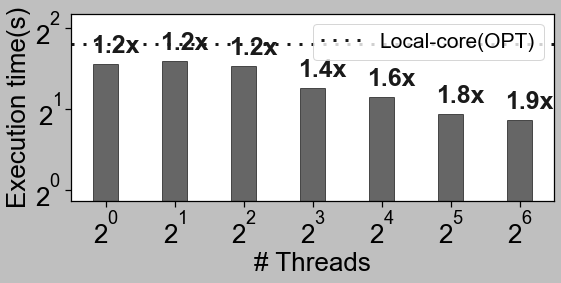

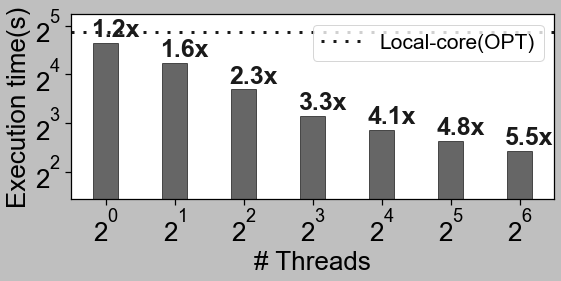

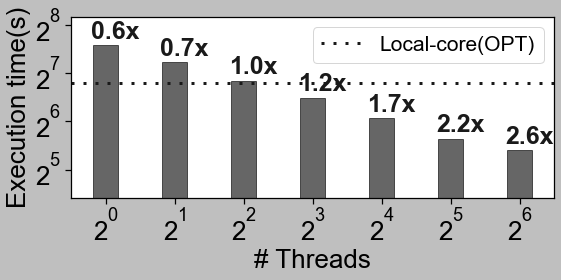

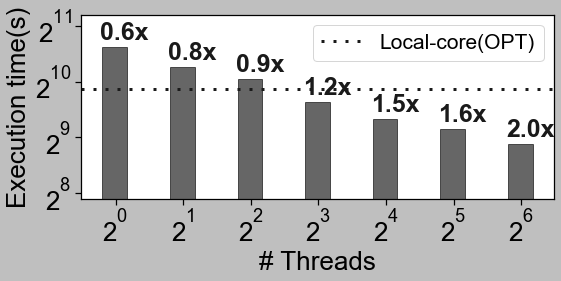

<Figure size 576x288 with 0 Axes>

In [45]:
from matplotlib import pyplot as plt 
from matplotlib.ticker import MaxNLocator
# import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
plt.style.use('grayscale')

save = True

include_algos = ['LocalP(B+CSR)2']
reference_algs = ['Local-core-OPTIV'] # Reference against.
col = ['r','g','b']
markers = ['o',"s",'x']
group_list = ['dataset']
# include_datasets = ['pref','congress','dblp','gowalla','weeplaces']
# include_datasets = ['bin_2','bin_5','contact','enron', 'congress']
# include_datasets = ['congress','dblp', 'aminer', 'gowalla','pref']
include_datasets = ['pref','congress','dblp', 'aminer']
# include_datasets = ['gowalla']
# columns = ['execution time']

tmp = df[df['dataset'].isin(include_datasets)].copy()
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

graph = None
df4 = tmp[tmp['algo'].isin(reference_algs)].copy()
df4 = df4.replace({"dataset": good_name_dataset})
thread_lim = 7
for dp in include_datasets:
    for i,alg in enumerate(reference_algs):
        ref_mean = df4[ (df4.algo == alg) & (df4.dataset==dp)]['execution time'].mean()
        # print(df4[ (df4.algo == alg) & (df4.dataset==dp)])
        working_df2 = working_df[working_df.dataset == dp].copy()
        # print(working_df2[y_axis])
        working_df2['speedup']  = ref_mean/ working_df2[y_axis]
        if len(working_df2)==0:
            continue 
        # print(working_df2)
        # print(working_df2.groupby(['num_threads'])['execution time'].mean())
        # _min = working_df[y_axis].min()
        # donotdrawline = working_df[y_axis].max() <= 20*_min
        # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
        # graph = sns.barplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind')
        # graph = sns.scatterplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind')
        # sns.lineplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind', marker = markers[i], label = alg)
        # plt.plot(working_df2['num_threads'][:thread_lim], working_df2[y_axis][:thread_lim],marker = markers[i], label = good_name_algo[alg],color = 'k')
        plt.bar(x = working_df2['num_threads'][:thread_lim], height = working_df2[y_axis][:thread_lim], width = working_df2['num_threads'][:thread_lim]/4, alpha = 0.6)
        for i,v in enumerate(working_df2['num_threads'][:thread_lim]):
            speedup = "{:.1f}x".format(ref_mean/ working_df2[y_axis][:thread_lim].values[i])
            # print(working_df2[y_axis][:thread_lim].values[i], speedup)
            plt.text(v-working_df2['num_threads'][:thread_lim].values[i]/7, working_df2[y_axis][:thread_lim].values[i]*1.1,str(speedup) , \
                     color='k', fontweight='bold',fontsize = fontsize-3)

            
        # plt.xticks(working_df2['num_threads'])
        # print(working_df2['num_threads'].values)
        # if i==0:
        # print(working_df2[y_axis])
        # print(working_df2['num_threads'])
        plt.axhline(ref_mean,color = 'k',linestyle = '--',dashes=(1, 3), label = good_name_algo[alg],linewidth = 3)
        plt.xlabel('# Threads', fontsize=fontsize-2)
        # plt.ylabel("Speedup", fontsize=fontsize)
        plt.ylabel('Execution time(s)', fontsize=fontsize-2)
        plt.yscale("log",base = 2)
        plt.xscale("log", base=2)
        plt.xticks(fontsize=fontsize-2)
        plt.yticks(fontsize=fontsize-2)
        # plt.title(dp)
    plt.legend(loc = 'upper right', fontsize=labelsize+1)
    # if dp!='pref':
    plt.ylim(np.min(working_df2[y_axis][:thread_lim].values)/2, np.max(working_df2[y_axis][:thread_lim].values)*1.5)
    # else:    
    #     plt.ylim(32, np.max(working_df2[y_axis][:thread_lim].values)*1.5)
    
    plt.tight_layout()
    filename = "parallel_time_"+dp
    if(save):
        plt.savefig("../fig/" + filename + ".pdf")
    else:
        print(filename)
    plt.show()
    plt.clf() 
        

    # include_datasets = ['bin_2','bin_5','contact','enron']
    # # columns = ['execution time']
    # working_df = df[df['dataset'].isin(include_datasets)].copy()
    # working_df = working_df[working_df['algo'].isin(include_algos)].copy()
    # # working_df['param_s'] = working_df['param_s'].astype(int)
    # # working_df = working_df.replace({"algo": good_name_algo})
    # working_df = working_df.replace({"dataset": good_name_dataset})
    # include_datasets = [good_name_dataset[d] for d in include_datasets]
    # y_axis = 'execution time'  

    # print(working_df.groupby(['dataset','algo'])['execution time'].mean())
    # # _min = working_df[y_axis].min()
    # # donotdrawline = working_df[y_axis].max() <= 20*_min
    # # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
    # ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, palette='colorblind', hue_order = order, order = include_datasets)
    # ax.yaxis.set_major_locator(MaxNLocator(5)) 
    # plt.xlabel('Dataset', fontsize=fontsize)
    # plt.ylabel(good_name[y_axis], fontsize=fontsize)
    # # plt.yscale("log")
    # plt.xticks(fontsize=fontsize)
    # plt.yticks(fontsize=fontsize)
    # # plt.
    # # ()
    # plt.legend(loc = 'upper center', bbox_to_anchor=(0.6,1), fontsize=labelsize-6)
    # plt.tight_layout()
    # filename = ("small " + y_axis).replace(" ", "_")
    # if(save):
    #     plt.savefig("results_final/fig/" + filename + ".pdf")
    # else:
    #     print(filename)
    #     plt.show()
    # plt.clf()


``Impact of Load-balancing``

In [47]:
df_par = pd.read_csv(parallel_outfolder+"results.csv", header = None)
df_par.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"]
df_par = df_par[df_par.num_threads.isin([1,2,4,8,16,32,64])].copy()
# df_par.head(60)
df_par_nolb = pd.read_csv(parallel_outfolder+"results_nolb.csv", header = None)
df_par_nolb.columns = ['algo', 'dataset', 'execution time', "num_threads", "total iteration"] 
df_tmp = pd.merge(df_par,df_par_nolb,how = 'inner', on=['dataset','num_threads'])
df_tmp['speedup'] = df_tmp['execution time_y']/df_tmp['execution time_x']
selected_df = df_tmp[df_tmp.dataset.isin(['congress','pref','aminer','dblp'])]
selected_df.groupby(by=['dataset'])['speedup'].max()

dataset
aminer      1.230799
congress    1.133264
dblp        1.235118
pref        1.055665
Name: speedup, dtype: float64

### Expt-3: Efficiency Analysis of E-Peel vs Peel

In [40]:
df = pd.read_csv("../output/nbrq_results.csv", header = None,delimiter=' ')
# df = pd.read_csv("epeel_ana/output/nbrq_results.csv", header = None,delimiter=' ')
df.columns = ['algo', 'dataset', 'execution time', "n_nbr_q"]
# df.head()

include_datasets = ['bin_5','dblp', 'enron', 'bin_2','contact', 'congress', 'aminer', 'pref']
epeel_df = df[df.algo == 'E-Peel'].copy()
# print(epeel_df)
peel_df = df[df.algo == 'Peel'].copy()
# print(peel_df)
epeel_df['alpha'] = epeel_df['n_nbr_q'].values/peel_df['n_nbr_q'].values
epeel_df['Speedup'] = peel_df['execution time'].values/epeel_df['execution time'].values
print(epeel_df.head(8))

      algo   dataset  execution time   n_nbr_q     alpha    Speedup
1   E-Peel     enron        0.833050      6737  0.384708  13.964719
3   E-Peel     bin_2        9.619980     27342  0.875000   1.123539
5   E-Peel     bin_5        7.802935     29132  1.013851   0.965231
7   E-Peel  congress     1090.318320    215997  1.007900   0.995327
9   E-Peel   contact        2.020313      8405  1.029646   0.951831
11  E-Peel      dblp      203.730784   2776754  0.641252   4.099650
13  E-Peel    aminer     2133.391792  30817693  0.698891   3.323541
15  E-Peel      pref   115106.413864    355091  1.308840   1.187574


[',', '.', 'o', 'v', '^', '<', '>', 'X']


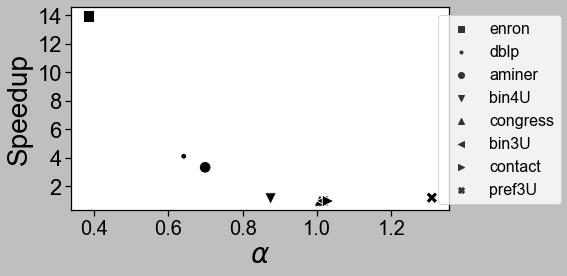

In [41]:
import matplotlib.pyplot as plt 
# from matplotlib.lines import Line2D
# from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')

epeel_df = epeel_df.sort_values('alpha')
# epeel_df = epeel_df.replace({"algo": good_name_algo})
epeel_df = epeel_df.replace({"dataset": good_name_dataset})
# marker_list = list(Line2D.markers)
marker_list = [',', '.', 'o', 'v', '^', '<', '>','X','8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', ]
print(marker_list[:len(epeel_df)])
ax = sns.scatterplot(x='alpha', y='Speedup', data=epeel_df, style='dataset', markers = marker_list[:len(epeel_df)], s= 135)
# plt.xticks([0.3,0.7,0.9,0.95,1.1])
ax.set_xlabel(r"${\alpha}$", fontsize=fontsize)
ax.set_ylabel("Speedup",fontsize= fontsize)
plt.xticks(fontsize=fontsize-8)
plt.yticks(fontsize=fontsize-6)
# plt.legend(loc = 'best', fontsize=labelsize-4, markerscale=2, mode = "expand", ncol = 4)
plt.legend(loc = 'upper left', fontsize=labelsize-4, bbox_to_anchor=(0.95,1))
plt.tight_layout()
plt.savefig('../fig/Epeel_exp.pdf')

In [42]:
epeel_df.head()

,algo,dataset,execution time,n_nbr_q,alpha,Speedup
1,E-Peel,enron,0.833050,6737,0.384708,13.964719
11,E-Peel,dblp,203.730784,2776754,0.641252,4.099650
13,E-Peel,aminer,2133.391792,30817693,0.698891,3.323541
3,E-Peel,bin4U,9.619980,27342,0.875000,1.123539
7,E-Peel,congress,1090.318320,215997,1.007900,0.995327
